## Claude's Attempt

In [1]:
# Cell 1

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
# Cell 2

# Load the pickle file
with open('../../../data/train/combined_train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Convert to DataFrame if it's not already
if not isinstance(data, pd.DataFrame):
    df = pd.DataFrame(data)
else:
    df = data

print(f"Dataset shape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nFirst few rows:")
print(df.head())
print(f"\nScore statistics:")
print(df['score'].describe())

Dataset shape: (175272, 11)

Column types:
accession         object
scoreset          object
ensp              object
pos                int64
ref_long          object
alt_long          object
score            float64
ref_embedding     object
alt_embedding     object
biotype           object
consequences      object
dtype: object

First few rows:
                    accession                 scoreset               ensp  \
0  urn:mavedb:00000069-a-2#24  urn:mavedb:00000069-a-2  ENSP00000252519.3   
1  urn:mavedb:00000069-a-2#25  urn:mavedb:00000069-a-2  ENSP00000252519.3   
2  urn:mavedb:00000069-a-2#26  urn:mavedb:00000069-a-2  ENSP00000252519.3   
3  urn:mavedb:00000069-a-2#27  urn:mavedb:00000069-a-2  ENSP00000252519.3   
4  urn:mavedb:00000069-a-2#28  urn:mavedb:00000069-a-2  ENSP00000252519.3   

   pos ref_long alt_long     score  \
0   76      Gln      Ter -1.822141   
1   75      Glu      Ter -1.841030   
2   74      Lys      Ter -2.129071   
3   73      Leu      Ter -1.624920  

In [3]:
# Cell 2.1

# Filter out extreme outliers MORE aggressively
print(f"Original dataset size: {len(df)}")

# Keep only values within a reasonable range (95th percentile and below)
lower_percentile = df['score'].quantile(0.05)
upper_percentile = df['score'].quantile(0.95)

df_filtered = df[(df['score'] >= lower_percentile) & (df['score'] <= upper_percentile)].copy()

print(f"Filtered dataset size: {len(df_filtered)}")
print(f"Removed {len(df) - len(df_filtered)} outliers ({100*(len(df) - len(df_filtered))/len(df):.1f}%)")
print(f"New score range: {df_filtered['score'].min():.4f} to {df_filtered['score'].max():.4f}")
print(f"New score mean: {df_filtered['score'].mean():.4f}, std: {df_filtered['score'].std():.4f}")

# Use filtered dataframe
df = df_filtered

Original dataset size: 175272
Filtered dataset size: 157744
Removed 17528 outliers (10.0%)
New score range: -0.9663 to 7.5770
New score mean: 0.3224, std: 1.3957


In [4]:
# Cell 3

# Check the shape of embeddings
sample_ref_emb = df['ref_embedding'].iloc[0]
sample_alt_emb = df['alt_embedding'].iloc[0]

print(f"Reference embedding shape: {sample_ref_emb.shape}")
print(f"Alternative embedding shape: {sample_alt_emb.shape}")
print(f"Reference embedding type: {type(sample_ref_emb)}")

# Get embedding dimension
embedding_dim = sample_ref_emb.shape[0]
print(f"\nEmbedding dimension: {embedding_dim}")

Reference embedding shape: torch.Size([1152])
Alternative embedding shape: torch.Size([1152])
Reference embedding type: <class 'torch.Tensor'>

Embedding dimension: 1152


In [5]:
# Cell 3.1

# Let's see the actual score distribution
print("Raw score statistics:")
print(f"Min: {df['score'].min()}")
print(f"Max: {df['score'].max()}")
print(f"Mean: {df['score'].mean()}")
print(f"Std: {df['score'].std()}")
print(f"Median: {df['score'].median()}")

# Check for outliers
print(f"\nPercentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"{p}th: {df['score'].quantile(p/100):.4f}")

Raw score statistics:
Min: -0.966335320451526
Max: 7.577049845
Mean: 0.3224106484349853
Std: 1.3956767849940086
Median: -0.028166120099430002

Percentiles:
1th: -0.9302
5th: -0.8067
25th: -0.2970
50th: -0.0282
75th: 0.4024
95th: 3.1591
99th: 7.0869


In [6]:
# Cell 4

from sklearn.preprocessing import MinMaxScaler

class ProteinScoreDataset(Dataset):
    def __init__(self, dataframe, score_scaler=None, fit_scaler=False):
        self.df = dataframe.reset_index(drop=True)
        
        # Use MinMaxScaler to scale to [0, 1] - more stable than StandardScaler
        if fit_scaler:
            self.score_scaler = MinMaxScaler(feature_range=(0, 1))
            scores = self.df['score'].values.reshape(-1, 1)
            self.score_scaler.fit(scores)
        else:
            self.score_scaler = score_scaler
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get embeddings
        ref_embedding = row['ref_embedding']
        alt_embedding = row['alt_embedding']
        
        # Ensure embeddings are torch tensors
        if not isinstance(ref_embedding, torch.Tensor):
            ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
        else:
            ref_embedding = ref_embedding.float()
            
        if not isinstance(alt_embedding, torch.Tensor):
            alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
        else:
            alt_embedding = alt_embedding.float()
        
        # Concatenate embeddings
        combined_embedding = torch.cat([ref_embedding, alt_embedding], dim=0)
        
        # Normalize embeddings (L2 normalization)
        norm = torch.norm(combined_embedding)
        if norm > 0:
            combined_embedding = combined_embedding / norm
        
        # Get normalized score (will be in [0, 1] range)
        score = self.score_scaler.transform([[row['score']]])[0][0]
        score = torch.tensor(score, dtype=torch.float32)
        
        return combined_embedding, score

In [7]:
# Cell 5

# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create datasets with normalization
train_dataset = ProteinScoreDataset(train_df, fit_scaler=True)
val_dataset = ProteinScoreDataset(val_df, score_scaler=train_dataset.score_scaler, fit_scaler=False)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nScore normalization - Min: {train_dataset.score_scaler.data_min_[0]:.4f}, Max: {train_dataset.score_scaler.data_max_[0]:.4f}")
print(f"Scores will be scaled to range: [0, 1]")

Training set size: 126195
Validation set size: 31549

Score normalization - Min: -0.9663, Max: 7.5770
Scores will be scaled to range: [0, 1]


In [8]:

# Cell 6

class ScorePredictionNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.1):
        super(ScorePredictionNet, self).__init__()
        
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.LayerNorm(hidden_dim))  # LayerNorm instead of BatchNorm
            self.layers.append(nn.Tanh())  # Tanh instead of ReLU - bounded output
            self.layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        self.output = nn.Linear(prev_dim, 1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid to ensure [0, 1] output
        
        # Initialize weights conservatively
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=0.1)
                nn.init.zeros_(layer.bias)
        
        nn.init.xavier_uniform_(self.output.weight, gain=0.01)
        nn.init.zeros_(self.output.bias)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x.squeeze()

# Initialize model
input_dim = embedding_dim * 2
model = ScorePredictionNet(input_dim)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Using device: {device}")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu

Model architecture:
ScorePredictionNet(
  (layers): ModuleList(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (6): Tanh()
    (7): Dropout(p=0.1, inplace=False)
  )
  (output): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 303,745


In [9]:
# Cell 7

# Training hyperparameters
learning_rate = 0.0001  # Can be slightly higher with [0,1] range
num_epochs = 100
patience = 15

# MSE is fine for [0, 1] range
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Loss function: MSE (scores in [0, 1] range)")

Learning rate: 0.0001
Number of epochs: 100
Loss function: MSE (scores in [0, 1] range)


In [10]:
# Cell 7.1

# Test a single batch to see where NaN originates
model.eval()
train_iter = iter(train_loader)
embeddings, scores = next(train_iter)

print("=" * 50)
print("DEBUGGING NaN ISSUE")
print("=" * 50)

# Check input data
print(f"\n1. INPUT DATA CHECK:")
print(f"   Embeddings shape: {embeddings.shape}")
print(f"   Embeddings contain NaN: {torch.isnan(embeddings).any()}")
print(f"   Embeddings contain Inf: {torch.isinf(embeddings).any()}")
print(f"   Embeddings min: {embeddings.min():.4f}, max: {embeddings.max():.4f}")
print(f"   Embeddings mean: {embeddings.mean():.4f}, std: {embeddings.std():.4f}")

print(f"\n   Scores shape: {scores.shape}")
print(f"   Scores contain NaN: {torch.isnan(scores).any()}")
print(f"   Scores contain Inf: {torch.isinf(scores).any()}")
print(f"   Scores min: {scores.min():.4f}, max: {scores.max():.4f}")
print(f"   Scores mean: {scores.mean():.4f}, std: {scores.std():.4f}")

# Check model forward pass
embeddings = embeddings.to(device)
scores = scores.to(device)

with torch.no_grad():
    predictions = model(embeddings)
    
print(f"\n2. MODEL OUTPUT CHECK:")
print(f"   Predictions contain NaN: {torch.isnan(predictions).any()}")
print(f"   Predictions contain Inf: {torch.isinf(predictions).any()}")
if not torch.isnan(predictions).any():
    print(f"   Predictions min: {predictions.min():.4f}, max: {predictions.max():.4f}")
    print(f"   Predictions mean: {predictions.mean():.4f}, std: {predictions.std():.4f}")

# Check loss calculation
loss = criterion(predictions, scores)
print(f"\n3. LOSS CHECK:")
print(f"   Loss value: {loss.item()}")
print(f"   Loss is NaN: {torch.isnan(loss)}")

# Check model weights
print(f"\n4. MODEL WEIGHTS CHECK:")
for name, param in model.named_parameters():
    if torch.isnan(param).any():
        print(f"   NaN found in {name}")
    if torch.isinf(param).any():
        print(f"   Inf found in {name}")
    print(f"   {name}: min={param.min():.4f}, max={param.max():.4f}, mean={param.abs().mean():.4f}")
    if len(list(model.named_parameters())) > 10:  # Only print first few if many layers
        break

print("=" * 50)

DEBUGGING NaN ISSUE

1. INPUT DATA CHECK:
   Embeddings shape: torch.Size([64, 2304])
   Embeddings contain NaN: False
   Embeddings contain Inf: False
   Embeddings min: -0.4950, max: 0.3358
   Embeddings mean: -0.0003, std: 0.0208

   Scores shape: torch.Size([64])
   Scores contain NaN: False
   Scores contain Inf: False
   Scores min: 0.0135, max: 0.9368
   Scores mean: 0.1491, std: 0.1706

2. MODEL OUTPUT CHECK:
   Predictions contain NaN: False
   Predictions contain Inf: False
   Predictions min: 0.4977, max: 0.5040
   Predictions mean: 0.5000, std: 0.0014

3. LOSS CHECK:
   Loss value: 0.1519547998905182
   Loss is NaN: False

4. MODEL WEIGHTS CHECK:
   layers.0.weight: min=-0.0050, max=0.0050, mean=0.0025
   layers.0.bias: min=0.0000, max=0.0000, mean=0.0000
   layers.1.weight: min=1.0000, max=1.0000, mean=1.0000
   layers.1.bias: min=0.0000, max=0.0000, mean=0.0000
   layers.4.weight: min=-0.0177, max=0.0177, mean=0.0089
   layers.4.bias: min=0.0000, max=0.0000, mean=0.0000
 

In [11]:
# Cell 8

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print("Starting training...\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for embeddings, scores in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        embeddings = embeddings.to(device)
        scores = scores.to(device)
        
        # Check for NaN in inputs BEFORE forward pass
        if torch.isnan(embeddings).any() or torch.isinf(embeddings).any():
            print(f"\n⚠️  NaN/Inf in embeddings at batch {train_batches}, skipping...")
            continue
        
        if torch.isnan(scores).any() or torch.isinf(scores).any():
            print(f"\n⚠️  NaN/Inf in scores at batch {train_batches}, skipping...")
            continue
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(embeddings)
        
        # Check predictions before loss
        if torch.isnan(predictions).any() or torch.isinf(predictions).any():
            print(f"\n⚠️  NaN/Inf in predictions at batch {train_batches}, skipping...")
            continue
        
        loss = criterion(predictions, scores)
        
        # Check for NaN loss before backward
        if torch.isnan(loss):
            print(f"\n⚠️  NaN loss detected at epoch {epoch+1}, batch {train_batches}")
            print(f"   Predictions: min={predictions.min():.4f}, max={predictions.max():.4f}")
            print(f"   Scores: min={scores.min():.4f}, max={scores.max():.4f}")
            print("   Skipping this batch...")
            continue
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    if train_batches == 0:
        print("All batches had NaN loss. Stopping training.")
        break
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for embeddings, scores in val_loader:
            embeddings = embeddings.to(device)
            scores = scores.to(device)
            
            # Skip batches with NaN
            if torch.isnan(embeddings).any() or torch.isnan(scores).any():
                continue
            
            predictions = model(embeddings)
            
            if torch.isnan(predictions).any():
                continue
            
            loss = criterion(predictions, scores)
            
            if not torch.isnan(loss):
                val_loss += loss.item()
                val_batches += 1
    
    if val_batches == 0:
        print("All validation batches had NaN loss. Stopping training.")
        break
        
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Update learning rate scheduler
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        print(f"  → New best model! (Val Loss: {best_val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print("\nTraining completed!")

Starting training...



Epoch 1/100 [Train]:  90%|████████▉ | 1772/1972 [00:22<00:02, 78.26it/s]


⚠️  NaN/Inf in embeddings at batch 1760, skipping...


Epoch 1/100 [Train]: 100%|██████████| 1972/1972 [00:25<00:00, 78.40it/s]


Epoch 1/100 - Train Loss: 0.0142, Val Loss: 0.0050
  → New best model! (Val Loss: 0.0050)


Epoch 2/100 [Train]:  96%|█████████▌| 1896/1972 [00:23<00:00, 76.88it/s]


⚠️  NaN/Inf in embeddings at batch 1881, skipping...


Epoch 2/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 79.59it/s]


Epoch 2/100 - Train Loss: 0.0054, Val Loss: 0.0049
  → New best model! (Val Loss: 0.0049)


Epoch 3/100 [Train]:  88%|████████▊ | 1742/1972 [00:22<00:02, 79.09it/s]


⚠️  NaN/Inf in embeddings at batch 1725, skipping...


Epoch 3/100 [Train]: 100%|██████████| 1972/1972 [00:25<00:00, 78.86it/s]


Epoch 3/100 - Train Loss: 0.0053, Val Loss: 0.0049
  → New best model! (Val Loss: 0.0049)


Epoch 4/100 [Train]:  75%|███████▌  | 1486/1972 [00:19<00:06, 76.66it/s]


⚠️  NaN/Inf in embeddings at batch 1476, skipping...


Epoch 4/100 [Train]: 100%|██████████| 1972/1972 [00:25<00:00, 77.40it/s]


Epoch 4/100 - Train Loss: 0.0053, Val Loss: 0.0048
  → New best model! (Val Loss: 0.0048)


Epoch 5/100 [Train]:  72%|███████▏  | 1428/1972 [00:18<00:07, 76.16it/s]


⚠️  NaN/Inf in embeddings at batch 1417, skipping...


Epoch 5/100 [Train]: 100%|██████████| 1972/1972 [00:25<00:00, 78.43it/s]


Epoch 5/100 - Train Loss: 0.0052, Val Loss: 0.0049


Epoch 6/100 [Train]:  81%|████████  | 1589/1972 [00:20<00:04, 80.57it/s]


⚠️  NaN/Inf in embeddings at batch 1573, skipping...


Epoch 6/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 78.96it/s]


Epoch 6/100 - Train Loss: 0.0052, Val Loss: 0.0048
  → New best model! (Val Loss: 0.0048)


Epoch 7/100 [Train]:  72%|███████▏  | 1410/1972 [00:17<00:06, 81.20it/s]


⚠️  NaN/Inf in embeddings at batch 1396, skipping...


Epoch 7/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 79.61it/s]


Epoch 7/100 - Train Loss: 0.0052, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 8/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 79.18it/s]


⚠️  NaN/Inf in embeddings at batch 1960, skipping...


Epoch 8/100 - Train Loss: 0.0052, Val Loss: 0.0048


Epoch 9/100 [Train]:  76%|███████▋  | 1505/1972 [00:18<00:05, 79.19it/s]


⚠️  NaN/Inf in embeddings at batch 1493, skipping...


Epoch 9/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 79.70it/s]


Epoch 9/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 10/100 [Train]:  85%|████████▍ | 1667/1972 [00:21<00:03, 81.15it/s]


⚠️  NaN/Inf in embeddings at batch 1653, skipping...


Epoch 10/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 79.31it/s]


Epoch 10/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 11/100 [Train]:  79%|███████▉  | 1560/1972 [00:19<00:05, 80.46it/s]


⚠️  NaN/Inf in embeddings at batch 1551, skipping...


Epoch 11/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 80.03it/s]


Epoch 11/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 12/100 [Train]:  57%|█████▋    | 1132/1972 [00:14<00:11, 76.15it/s]


⚠️  NaN/Inf in embeddings at batch 1116, skipping...


Epoch 12/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 79.25it/s]


Epoch 12/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 13/100 [Train]:  68%|██████▊   | 1345/1972 [00:16<00:07, 81.44it/s]


⚠️  NaN/Inf in embeddings at batch 1336, skipping...


Epoch 13/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 80.20it/s]


Epoch 13/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 14/100 [Train]:  24%|██▍       | 473/1972 [00:05<00:18, 80.85it/s]


⚠️  NaN/Inf in embeddings at batch 462, skipping...


Epoch 14/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 79.75it/s]


Epoch 14/100 - Train Loss: 0.0051, Val Loss: 0.0047
  → New best model! (Val Loss: 0.0047)


Epoch 15/100 [Train]:  70%|██████▉   | 1374/1972 [00:16<00:07, 80.76it/s]


⚠️  NaN/Inf in embeddings at batch 1360, skipping...


Epoch 15/100 [Train]: 100%|██████████| 1972/1972 [00:24<00:00, 80.89it/s]


Epoch 15/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 16/100 [Train]:  35%|███▌      | 695/1972 [00:08<00:15, 80.93it/s]


⚠️  NaN/Inf in embeddings at batch 683, skipping...


Epoch 16/100 [Train]: 100%|██████████| 1972/1972 [00:28<00:00, 68.18it/s]


Epoch 16/100 - Train Loss: 0.0051, Val Loss: 0.0048


Epoch 17/100 [Train]:  19%|█▊        | 367/1972 [00:14<01:17, 20.67it/s]


⚠️  NaN/Inf in embeddings at batch 364, skipping...


Epoch 17/100 [Train]: 100%|██████████| 1972/1972 [00:56<00:00, 35.14it/s]


Epoch 17/100 - Train Loss: 0.0051, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 18/100 [Train]:  88%|████████▊ | 1735/1972 [00:55<00:07, 32.55it/s]


⚠️  NaN/Inf in embeddings at batch 1728, skipping...


Epoch 18/100 [Train]: 100%|██████████| 1972/1972 [01:03<00:00, 30.98it/s]


Epoch 18/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 19/100 [Train]:  76%|███████▌  | 1496/1972 [00:50<00:13, 34.09it/s]


⚠️  NaN/Inf in embeddings at batch 1489, skipping...


Epoch 19/100 [Train]: 100%|██████████| 1972/1972 [01:04<00:00, 30.43it/s]


Epoch 19/100 - Train Loss: 0.0051, Val Loss: 0.0047


Epoch 20/100 [Train]:  29%|██▉       | 569/1972 [00:19<00:37, 37.28it/s]


⚠️  NaN/Inf in embeddings at batch 563, skipping...


Epoch 20/100 [Train]: 100%|██████████| 1972/1972 [01:04<00:00, 30.76it/s]


Epoch 20/100 - Train Loss: 0.0050, Val Loss: 0.0047


Epoch 21/100 [Train]:  24%|██▍       | 474/1972 [00:14<00:44, 33.68it/s]


⚠️  NaN/Inf in embeddings at batch 468, skipping...


Epoch 21/100 [Train]: 100%|██████████| 1972/1972 [01:17<00:00, 25.49it/s]


Epoch 21/100 - Train Loss: 0.0050, Val Loss: 0.0047


Epoch 22/100 [Train]:  50%|█████     | 995/1972 [00:54<01:13, 13.37it/s]


⚠️  NaN/Inf in embeddings at batch 993, skipping...


Epoch 22/100 [Train]: 100%|██████████| 1972/1972 [02:16<00:00, 14.46it/s]


Epoch 22/100 - Train Loss: 0.0050, Val Loss: 0.0047


Epoch 23/100 [Train]:  81%|████████▏ | 1603/1972 [00:43<00:09, 37.09it/s]


⚠️  NaN/Inf in embeddings at batch 1597, skipping...


Epoch 23/100 [Train]: 100%|██████████| 1972/1972 [00:55<00:00, 35.71it/s]


Epoch 23/100 - Train Loss: 0.0050, Val Loss: 0.0047


Epoch 24/100 [Train]:  25%|██▌       | 493/1972 [00:26<00:57, 25.68it/s]


⚠️  NaN/Inf in embeddings at batch 489, skipping...


Epoch 24/100 [Train]: 100%|██████████| 1972/1972 [01:31<00:00, 21.53it/s]


Epoch 24/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 25/100 [Train]:  13%|█▎        | 262/1972 [00:09<01:00, 28.24it/s]


⚠️  NaN/Inf in embeddings at batch 257, skipping...


Epoch 25/100 [Train]: 100%|██████████| 1972/1972 [01:16<00:00, 25.83it/s]


Epoch 25/100 - Train Loss: 0.0050, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 26/100 [Train]:  74%|███████▍  | 1457/1972 [01:04<00:17, 30.14it/s]


⚠️  NaN/Inf in embeddings at batch 1455, skipping...


Epoch 26/100 [Train]: 100%|██████████| 1972/1972 [01:27<00:00, 22.42it/s]


Epoch 26/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 27/100 [Train]:  89%|████████▉ | 1758/1972 [01:05<00:07, 28.54it/s]


⚠️  NaN/Inf in embeddings at batch 1756, skipping...


Epoch 27/100 [Train]: 100%|██████████| 1972/1972 [01:12<00:00, 27.28it/s]


Epoch 27/100 - Train Loss: 0.0049, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 28/100 [Train]:  84%|████████▍ | 1658/1972 [01:09<00:16, 18.68it/s]


⚠️  NaN/Inf in embeddings at batch 1655, skipping...


Epoch 28/100 [Train]: 100%|██████████| 1972/1972 [01:24<00:00, 23.23it/s]


Epoch 28/100 - Train Loss: 0.0049, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 29/100 [Train]:  29%|██▉       | 573/1972 [00:25<00:54, 25.49it/s]


⚠️  NaN/Inf in embeddings at batch 568, skipping...


Epoch 29/100 [Train]: 100%|██████████| 1972/1972 [01:29<00:00, 22.09it/s]


Epoch 29/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 30/100 [Train]:  54%|█████▍    | 1068/1972 [00:47<00:35, 25.30it/s]


⚠️  NaN/Inf in embeddings at batch 1064, skipping...


Epoch 30/100 [Train]: 100%|██████████| 1972/1972 [01:18<00:00, 25.12it/s]


Epoch 30/100 - Train Loss: 0.0050, Val Loss: 0.0046


Epoch 31/100 [Train]:   6%|▋         | 125/1972 [00:04<01:00, 30.29it/s]


⚠️  NaN/Inf in embeddings at batch 122, skipping...


Epoch 31/100 [Train]: 100%|██████████| 1972/1972 [01:24<00:00, 23.26it/s]


Epoch 31/100 - Train Loss: 0.0049, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 32/100 [Train]:  66%|██████▋   | 1308/1972 [00:56<00:26, 24.62it/s]


⚠️  NaN/Inf in embeddings at batch 1303, skipping...


Epoch 32/100 [Train]: 100%|██████████| 1972/1972 [01:24<00:00, 23.26it/s]


Epoch 32/100 - Train Loss: 0.0049, Val Loss: 0.0046
  → New best model! (Val Loss: 0.0046)


Epoch 33/100 [Train]:  12%|█▏        | 232/1972 [00:10<01:09, 25.15it/s]


⚠️  NaN/Inf in embeddings at batch 226, skipping...


Epoch 33/100 [Train]: 100%|██████████| 1972/1972 [01:12<00:00, 27.12it/s]


Epoch 33/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 34/100 [Train]:  24%|██▍       | 469/1972 [00:14<00:44, 33.63it/s]


⚠️  NaN/Inf in embeddings at batch 462, skipping...


Epoch 34/100 [Train]: 100%|██████████| 1972/1972 [01:22<00:00, 24.00it/s]


Epoch 34/100 - Train Loss: 0.0049, Val Loss: 0.0047


Epoch 35/100 [Train]:  96%|█████████▋| 1900/1972 [01:22<00:03, 23.61it/s]


⚠️  NaN/Inf in embeddings at batch 1897, skipping...


Epoch 35/100 [Train]: 100%|██████████| 1972/1972 [01:26<00:00, 22.85it/s]


Epoch 35/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 36/100 [Train]:  11%|█▏        | 225/1972 [00:10<01:18, 22.34it/s]


⚠️  NaN/Inf in embeddings at batch 222, skipping...


Epoch 36/100 [Train]: 100%|██████████| 1972/1972 [01:26<00:00, 22.72it/s]


Epoch 36/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 37/100 [Train]:   1%|          | 18/1972 [00:00<01:11, 27.35it/s]


⚠️  NaN/Inf in embeddings at batch 13, skipping...


Epoch 37/100 [Train]: 100%|██████████| 1972/1972 [01:10<00:00, 28.11it/s]


Epoch 37/100 - Train Loss: 0.0049, Val Loss: 0.0047


Epoch 38/100 [Train]:  58%|█████▊    | 1151/1972 [00:53<00:31, 25.79it/s]


⚠️  NaN/Inf in embeddings at batch 1146, skipping...


Epoch 38/100 [Train]: 100%|██████████| 1972/1972 [01:30<00:00, 21.91it/s]


Epoch 38/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 39/100 [Train]:  60%|██████    | 1188/1972 [00:50<00:38, 20.51it/s]


⚠️  NaN/Inf in embeddings at batch 1183, skipping...


Epoch 39/100 [Train]: 100%|██████████| 1972/1972 [01:24<00:00, 23.28it/s]


Epoch 39/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 40/100 [Train]:  30%|███       | 600/1972 [00:26<00:50, 27.01it/s]


⚠️  NaN/Inf in embeddings at batch 594, skipping...


Epoch 40/100 [Train]: 100%|██████████| 1972/1972 [01:13<00:00, 27.00it/s]


Epoch 40/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 41/100 [Train]:  17%|█▋        | 329/1972 [00:09<00:34, 48.07it/s]


⚠️  NaN/Inf in embeddings at batch 322, skipping...


Epoch 41/100 [Train]: 100%|██████████| 1972/1972 [00:54<00:00, 36.23it/s]


Epoch 41/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 42/100 [Train]:  62%|██████▏   | 1223/1972 [00:30<00:16, 46.30it/s]


⚠️  NaN/Inf in embeddings at batch 1212, skipping...


Epoch 42/100 [Train]: 100%|██████████| 1972/1972 [00:54<00:00, 36.28it/s]


Epoch 42/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 43/100 [Train]:  62%|██████▏   | 1232/1972 [00:40<00:24, 30.40it/s]


⚠️  NaN/Inf in embeddings at batch 1228, skipping...


Epoch 43/100 [Train]: 100%|██████████| 1972/1972 [01:07<00:00, 29.30it/s]


Epoch 43/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 44/100 [Train]:  35%|███▍      | 689/1972 [00:23<00:33, 37.74it/s]


⚠️  NaN/Inf in embeddings at batch 684, skipping...


Epoch 44/100 [Train]: 100%|██████████| 1972/1972 [01:05<00:00, 30.26it/s]


Epoch 44/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 45/100 [Train]:  19%|█▉        | 383/1972 [00:12<00:40, 39.03it/s]


⚠️  NaN/Inf in embeddings at batch 378, skipping...


Epoch 45/100 [Train]: 100%|██████████| 1972/1972 [00:53<00:00, 37.01it/s]


Epoch 45/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 46/100 [Train]:  25%|██▌       | 497/1972 [00:15<00:42, 34.35it/s]


⚠️  NaN/Inf in embeddings at batch 492, skipping...


Epoch 46/100 [Train]: 100%|██████████| 1972/1972 [01:11<00:00, 27.44it/s]


Epoch 46/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 47/100 [Train]:  24%|██▍       | 471/1972 [00:13<00:39, 37.78it/s]


⚠️  NaN/Inf in embeddings at batch 465, skipping...


Epoch 47/100 [Train]: 100%|██████████| 1972/1972 [00:58<00:00, 33.57it/s]


Epoch 47/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 48/100 [Train]:  12%|█▏        | 232/1972 [00:06<00:50, 34.63it/s]


⚠️  NaN/Inf in embeddings at batch 226, skipping...


Epoch 48/100 [Train]: 100%|██████████| 1972/1972 [01:05<00:00, 30.09it/s]


Epoch 48/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 49/100 [Train]:  35%|███▍      | 690/1972 [00:23<00:41, 30.77it/s]


⚠️  NaN/Inf in embeddings at batch 686, skipping...


Epoch 49/100 [Train]: 100%|██████████| 1972/1972 [01:02<00:00, 31.43it/s]


Epoch 49/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 50/100 [Train]:  40%|███▉      | 781/1972 [00:19<00:29, 40.68it/s]


⚠️  NaN/Inf in embeddings at batch 773, skipping...


Epoch 50/100 [Train]: 100%|██████████| 1972/1972 [00:56<00:00, 34.97it/s]


Epoch 50/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 51/100 [Train]:  20%|█▉        | 393/1972 [00:13<01:01, 25.51it/s]


⚠️  NaN/Inf in embeddings at batch 388, skipping...


Epoch 51/100 [Train]: 100%|██████████| 1972/1972 [01:09<00:00, 28.20it/s]


Epoch 51/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 52/100 [Train]:  57%|█████▋    | 1126/1972 [00:34<00:23, 36.71it/s]


⚠️  NaN/Inf in embeddings at batch 1120, skipping...


Epoch 52/100 [Train]: 100%|██████████| 1972/1972 [00:59<00:00, 32.87it/s]


Epoch 52/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 53/100 [Train]:  17%|█▋        | 330/1972 [00:10<00:57, 28.47it/s]


⚠️  NaN/Inf in embeddings at batch 325, skipping...


Epoch 53/100 [Train]: 100%|██████████| 1972/1972 [01:04<00:00, 30.34it/s]


Epoch 53/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 54/100 [Train]:  86%|████████▌ | 1696/1972 [00:39<00:07, 39.02it/s]


⚠️  NaN/Inf in embeddings at batch 1688, skipping...


Epoch 54/100 [Train]: 100%|██████████| 1972/1972 [00:48<00:00, 41.00it/s]


Epoch 54/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 55/100 [Train]:  15%|█▌        | 297/1972 [00:09<00:52, 32.20it/s]


⚠️  NaN/Inf in embeddings at batch 293, skipping...


Epoch 55/100 [Train]: 100%|██████████| 1972/1972 [00:58<00:00, 33.66it/s]


Epoch 55/100 - Train Loss: 0.0049, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 56/100 [Train]:  47%|████▋     | 920/1972 [00:25<00:29, 35.76it/s]


⚠️  NaN/Inf in embeddings at batch 914, skipping...


Epoch 56/100 [Train]: 100%|██████████| 1972/1972 [00:57<00:00, 34.48it/s]


Epoch 56/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 57/100 [Train]:  84%|████████▎ | 1651/1972 [00:54<00:09, 35.00it/s]


⚠️  NaN/Inf in embeddings at batch 1646, skipping...


Epoch 57/100 [Train]: 100%|██████████| 1972/1972 [01:05<00:00, 29.97it/s]


Epoch 57/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 58/100 [Train]:  96%|█████████▌| 1897/1972 [00:54<00:01, 45.31it/s]


⚠️  NaN/Inf in embeddings at batch 1892, skipping...


Epoch 58/100 [Train]: 100%|██████████| 1972/1972 [00:56<00:00, 34.94it/s]


Epoch 58/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 59/100 [Train]:  80%|████████  | 1586/1972 [00:50<00:13, 28.10it/s]


⚠️  NaN/Inf in embeddings at batch 1579, skipping...


Epoch 59/100 [Train]: 100%|██████████| 1972/1972 [01:03<00:00, 30.96it/s]


Epoch 59/100 - Train Loss: 0.0049, Val Loss: 0.0046


Epoch 60/100 [Train]:  42%|████▏     | 837/1972 [00:28<00:36, 31.26it/s]


⚠️  NaN/Inf in embeddings at batch 831, skipping...


Epoch 60/100 [Train]: 100%|██████████| 1972/1972 [01:08<00:00, 29.00it/s]


Epoch 60/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 61/100 [Train]:  78%|███████▊  | 1534/1972 [00:57<00:09, 48.05it/s]


⚠️  NaN/Inf in embeddings at batch 1525, skipping...


Epoch 61/100 [Train]: 100%|██████████| 1972/1972 [01:10<00:00, 27.96it/s]


Epoch 61/100 - Train Loss: 0.0049, Val Loss: 0.0045


Epoch 62/100 [Train]:  23%|██▎       | 458/1972 [00:17<00:48, 31.38it/s]


⚠️  NaN/Inf in embeddings at batch 452, skipping...


Epoch 62/100 [Train]: 100%|██████████| 1972/1972 [00:57<00:00, 34.37it/s]


Epoch 62/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 63/100 [Train]:  32%|███▏      | 626/1972 [00:19<00:32, 41.47it/s]


⚠️  NaN/Inf in embeddings at batch 623, skipping...


Epoch 63/100 [Train]: 100%|██████████| 1972/1972 [01:00<00:00, 32.73it/s]


Epoch 63/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 64/100 [Train]:  15%|█▌        | 296/1972 [00:11<01:00, 27.60it/s]


⚠️  NaN/Inf in embeddings at batch 289, skipping...


Epoch 64/100 [Train]: 100%|██████████| 1972/1972 [01:03<00:00, 31.22it/s]


Epoch 64/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 65/100 [Train]:  42%|████▏     | 823/1972 [00:18<00:23, 49.03it/s]


⚠️  NaN/Inf in embeddings at batch 814, skipping...


Epoch 65/100 [Train]: 100%|██████████| 1972/1972 [00:50<00:00, 38.76it/s]


Epoch 65/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 66/100 [Train]:   2%|▏         | 42/1972 [00:01<01:12, 26.50it/s]


⚠️  NaN/Inf in embeddings at batch 35, skipping...


Epoch 66/100 [Train]: 100%|██████████| 1972/1972 [01:06<00:00, 29.62it/s]


Epoch 66/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 67/100 [Train]:  11%|█▏        | 224/1972 [00:07<00:53, 32.44it/s]


⚠️  NaN/Inf in embeddings at batch 219, skipping...


Epoch 67/100 [Train]: 100%|██████████| 1972/1972 [01:01<00:00, 32.17it/s]


Epoch 67/100 - Train Loss: 0.0048, Val Loss: 0.0046


Epoch 68/100 [Train]:   9%|▉         | 179/1972 [00:05<00:56, 31.93it/s]


⚠️  NaN/Inf in embeddings at batch 173, skipping...


Epoch 68/100 [Train]: 100%|██████████| 1972/1972 [00:59<00:00, 33.21it/s]


Epoch 68/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 69/100 [Train]:  27%|██▋       | 535/1972 [00:12<00:34, 42.06it/s]


⚠️  NaN/Inf in embeddings at batch 531, skipping...


Epoch 69/100 [Train]: 100%|██████████| 1972/1972 [00:44<00:00, 43.92it/s]


Epoch 69/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 70/100 [Train]:  70%|██████▉   | 1374/1972 [00:43<00:18, 32.73it/s]


⚠️  NaN/Inf in embeddings at batch 1367, skipping...


Epoch 70/100 [Train]: 100%|██████████| 1972/1972 [01:01<00:00, 32.20it/s]


Epoch 70/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 71/100 [Train]:   6%|▌         | 121/1972 [00:05<01:03, 28.96it/s]


⚠️  NaN/Inf in embeddings at batch 116, skipping...


Epoch 71/100 [Train]: 100%|██████████| 1972/1972 [01:03<00:00, 30.90it/s]


Epoch 71/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 72/100 [Train]:  22%|██▏       | 434/1972 [00:14<00:42, 36.13it/s]


⚠️  NaN/Inf in embeddings at batch 428, skipping...


Epoch 72/100 [Train]: 100%|██████████| 1972/1972 [00:52<00:00, 37.91it/s]


Epoch 72/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 73/100 [Train]:  96%|█████████▌| 1889/1972 [00:45<00:01, 43.10it/s]


⚠️  NaN/Inf in embeddings at batch 1883, skipping...


Epoch 73/100 [Train]: 100%|██████████| 1972/1972 [00:48<00:00, 40.76it/s]


Epoch 73/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 74/100 [Train]:  95%|█████████▍| 1873/1972 [00:58<00:03, 25.57it/s]


⚠️  NaN/Inf in embeddings at batch 1868, skipping...


Epoch 74/100 [Train]: 100%|██████████| 1972/1972 [01:03<00:00, 31.19it/s]


Epoch 74/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 75/100 [Train]:  45%|████▍     | 880/1972 [00:26<00:43, 25.16it/s]


⚠️  NaN/Inf in embeddings at batch 876, skipping...


Epoch 75/100 [Train]: 100%|██████████| 1972/1972 [00:59<00:00, 32.97it/s]


Epoch 75/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 76/100 [Train]:  63%|██████▎   | 1252/1972 [00:33<00:18, 38.70it/s]


⚠️  NaN/Inf in embeddings at batch 1245, skipping...


Epoch 76/100 [Train]: 100%|██████████| 1972/1972 [00:53<00:00, 36.94it/s]


Epoch 76/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 77/100 [Train]:  32%|███▏      | 629/1972 [00:14<00:28, 47.53it/s]


⚠️  NaN/Inf in embeddings at batch 625, skipping...


Epoch 77/100 [Train]: 100%|██████████| 1972/1972 [00:41<00:00, 47.14it/s]


Epoch 77/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 78/100 [Train]:  48%|████▊     | 950/1972 [00:20<00:25, 40.35it/s]


⚠️  NaN/Inf in embeddings at batch 944, skipping...


Epoch 78/100 [Train]: 100%|██████████| 1972/1972 [00:46<00:00, 42.45it/s]


Epoch 78/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 79/100 [Train]:  98%|█████████▊| 1927/1972 [00:54<00:01, 40.33it/s]


⚠️  NaN/Inf in embeddings at batch 1922, skipping...


Epoch 79/100 [Train]: 100%|██████████| 1972/1972 [00:55<00:00, 35.54it/s]


Epoch 79/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 80/100 [Train]:  65%|██████▌   | 1289/1972 [00:38<00:25, 26.46it/s]


⚠️  NaN/Inf in embeddings at batch 1285, skipping...


Epoch 80/100 [Train]: 100%|██████████| 1972/1972 [01:00<00:00, 32.81it/s]


Epoch 80/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 81/100 [Train]:  36%|███▋      | 715/1972 [00:23<00:33, 37.77it/s]


⚠️  NaN/Inf in embeddings at batch 710, skipping...


Epoch 81/100 [Train]: 100%|██████████| 1972/1972 [00:59<00:00, 32.90it/s]


Epoch 81/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 82/100 [Train]:  20%|██        | 396/1972 [00:08<00:31, 50.32it/s]


⚠️  NaN/Inf in embeddings at batch 388, skipping...


Epoch 82/100 [Train]: 100%|██████████| 1972/1972 [00:44<00:00, 44.72it/s]


Epoch 82/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 83/100 [Train]:  86%|████████▌ | 1691/1972 [01:02<00:09, 29.88it/s]


⚠️  NaN/Inf in embeddings at batch 1687, skipping...


Epoch 83/100 [Train]: 100%|██████████| 1972/1972 [01:13<00:00, 26.89it/s]


Epoch 83/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 84/100 [Train]:  17%|█▋        | 327/1972 [00:13<01:02, 26.47it/s]


⚠️  NaN/Inf in embeddings at batch 322, skipping...


Epoch 84/100 [Train]: 100%|██████████| 1972/1972 [01:14<00:00, 26.37it/s]


Epoch 84/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 85/100 [Train]:  43%|████▎     | 848/1972 [00:18<00:21, 52.03it/s]


⚠️  NaN/Inf in embeddings at batch 840, skipping...


Epoch 85/100 [Train]: 100%|██████████| 1972/1972 [00:42<00:00, 46.65it/s]


Epoch 85/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 86/100 [Train]:  83%|████████▎ | 1636/1972 [00:52<00:14, 22.65it/s]


⚠️  NaN/Inf in embeddings at batch 1633, skipping...


Epoch 86/100 [Train]: 100%|██████████| 1972/1972 [01:02<00:00, 31.68it/s]


Epoch 86/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 87/100 [Train]:  73%|███████▎  | 1435/1972 [00:47<00:13, 39.63it/s]


⚠️  NaN/Inf in embeddings at batch 1427, skipping...


Epoch 87/100 [Train]: 100%|██████████| 1972/1972 [01:02<00:00, 31.56it/s]


Epoch 87/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 88/100 [Train]:  64%|██████▍   | 1271/1972 [00:39<00:18, 38.71it/s]


⚠️  NaN/Inf in embeddings at batch 1263, skipping...


Epoch 88/100 [Train]: 100%|██████████| 1972/1972 [00:55<00:00, 35.37it/s]


Epoch 88/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 89/100 [Train]:  81%|████████▏ | 1606/1972 [00:36<00:07, 46.88it/s]


⚠️  NaN/Inf in embeddings at batch 1597, skipping...


Epoch 89/100 [Train]: 100%|██████████| 1972/1972 [00:44<00:00, 43.97it/s]


Epoch 89/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 90/100 [Train]:   6%|▌         | 113/1972 [00:03<00:56, 33.14it/s]


⚠️  NaN/Inf in embeddings at batch 107, skipping...


Epoch 90/100 [Train]: 100%|██████████| 1972/1972 [00:59<00:00, 33.04it/s]


Epoch 90/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 91/100 [Train]:  78%|███████▊  | 1531/1972 [00:47<00:11, 36.97it/s]


⚠️  NaN/Inf in embeddings at batch 1527, skipping...


Epoch 91/100 [Train]: 100%|██████████| 1972/1972 [01:00<00:00, 32.74it/s]


Epoch 91/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 92/100 [Train]:  83%|████████▎ | 1642/1972 [00:48<00:08, 37.86it/s]


⚠️  NaN/Inf in embeddings at batch 1637, skipping...


Epoch 92/100 [Train]: 100%|██████████| 1972/1972 [00:57<00:00, 34.10it/s]


Epoch 92/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 93/100 [Train]:  54%|█████▍    | 1069/1972 [00:26<00:20, 43.24it/s]


⚠️  NaN/Inf in embeddings at batch 1062, skipping...


Epoch 93/100 [Train]: 100%|██████████| 1972/1972 [00:48<00:00, 40.42it/s]


Epoch 93/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 94/100 [Train]:  77%|███████▋  | 1519/1972 [00:47<00:12, 35.04it/s]


⚠️  NaN/Inf in embeddings at batch 1513, skipping...


Epoch 94/100 [Train]: 100%|██████████| 1972/1972 [01:00<00:00, 32.43it/s]


Epoch 94/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 95/100 [Train]:  24%|██▍       | 470/1972 [00:15<00:42, 35.20it/s]


⚠️  NaN/Inf in embeddings at batch 465, skipping...


Epoch 95/100 [Train]: 100%|██████████| 1972/1972 [01:00<00:00, 32.52it/s]


Epoch 95/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 96/100 [Train]:   5%|▍         | 92/1972 [00:02<00:55, 33.67it/s]


⚠️  NaN/Inf in embeddings at batch 84, skipping...


Epoch 96/100 [Train]: 100%|██████████| 1972/1972 [01:01<00:00, 31.90it/s]


Epoch 96/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 97/100 [Train]:  88%|████████▊ | 1734/1972 [00:47<00:05, 40.88it/s]


⚠️  NaN/Inf in embeddings at batch 1729, skipping...


Epoch 97/100 [Train]: 100%|██████████| 1972/1972 [00:53<00:00, 36.59it/s]


Epoch 97/100 - Train Loss: 0.0048, Val Loss: 0.0045


Epoch 98/100 [Train]:  54%|█████▎    | 1057/1972 [00:27<00:34, 26.59it/s]


⚠️  NaN/Inf in embeddings at batch 1051, skipping...


Epoch 98/100 [Train]: 100%|██████████| 1972/1972 [00:52<00:00, 37.88it/s]


Epoch 98/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 99/100 [Train]:  27%|██▋       | 542/1972 [00:15<00:45, 31.21it/s]


⚠️  NaN/Inf in embeddings at batch 536, skipping...


Epoch 99/100 [Train]: 100%|██████████| 1972/1972 [00:57<00:00, 34.18it/s]


Epoch 99/100 - Train Loss: 0.0048, Val Loss: 0.0045
  → New best model! (Val Loss: 0.0045)


Epoch 100/100 [Train]:  40%|███▉      | 783/1972 [00:22<00:42, 28.07it/s]


⚠️  NaN/Inf in embeddings at batch 777, skipping...


Epoch 100/100 [Train]: 100%|██████████| 1972/1972 [00:54<00:00, 36.18it/s]


Epoch 100/100 - Train Loss: 0.0048, Val Loss: 0.0045

Training completed!


In [ ]:
# Cell 9

# Model is already trained, just set to eval mode
model.eval()

# Get predictions for validation set
val_predictions = []
val_actuals = []
val_predictions_normalized = []
val_actuals_normalized = []

with torch.no_grad():
    for embeddings, scores in val_loader:
        embeddings = embeddings.to(device)
        scores_normalized = scores.to(device)
        predictions_normalized = model(embeddings)
        
        # Store normalized predictions and actuals
        val_predictions_normalized.extend(predictions_normalized.cpu().numpy())
        val_actuals_normalized.extend(scores_normalized.cpu().numpy())

# Convert to arrays
val_predictions_normalized = np.array(val_predictions_normalized).reshape(-1, 1)
val_actuals_normalized = np.array(val_actuals_normalized).reshape(-1, 1)

# Inverse transform to get original scale
val_predictions = train_dataset.score_scaler.inverse_transform(val_predictions_normalized).flatten()
val_actuals = train_dataset.score_scaler.inverse_transform(val_actuals_normalized).flatten()

# Calculate metrics on original scale
mse = mean_squared_error(val_actuals, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actuals, val_predictions)
r2 = r2_score(val_actuals, val_predictions)

print("=" * 50)
print("VALIDATION SET RESULTS (Original Scale)")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)

# Also show normalized metrics for reference
mse_norm = mean_squared_error(val_actuals_normalized, val_predictions_normalized)
print(f"\nNormalized MSE: {mse_norm:.4f}")

VALIDATION SET RESULTS (Original Scale)
Mean Squared Error (MSE):  0.3264
Root Mean Squared Error (RMSE): 0.5713
Mean Absolute Error (MAE): 0.3157
R² Score: 0.8252

Normalized MSE: 0.0045


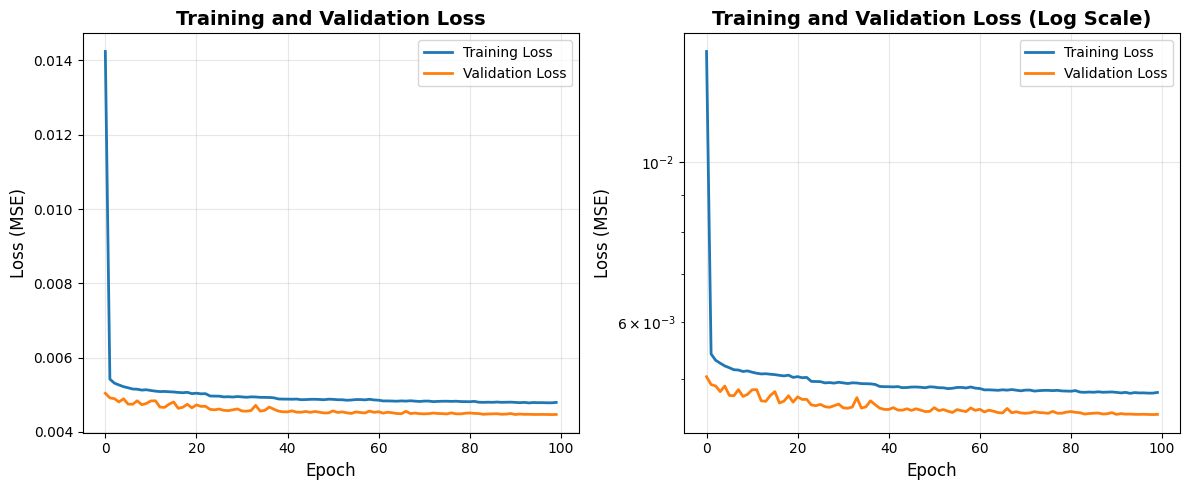

In [14]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

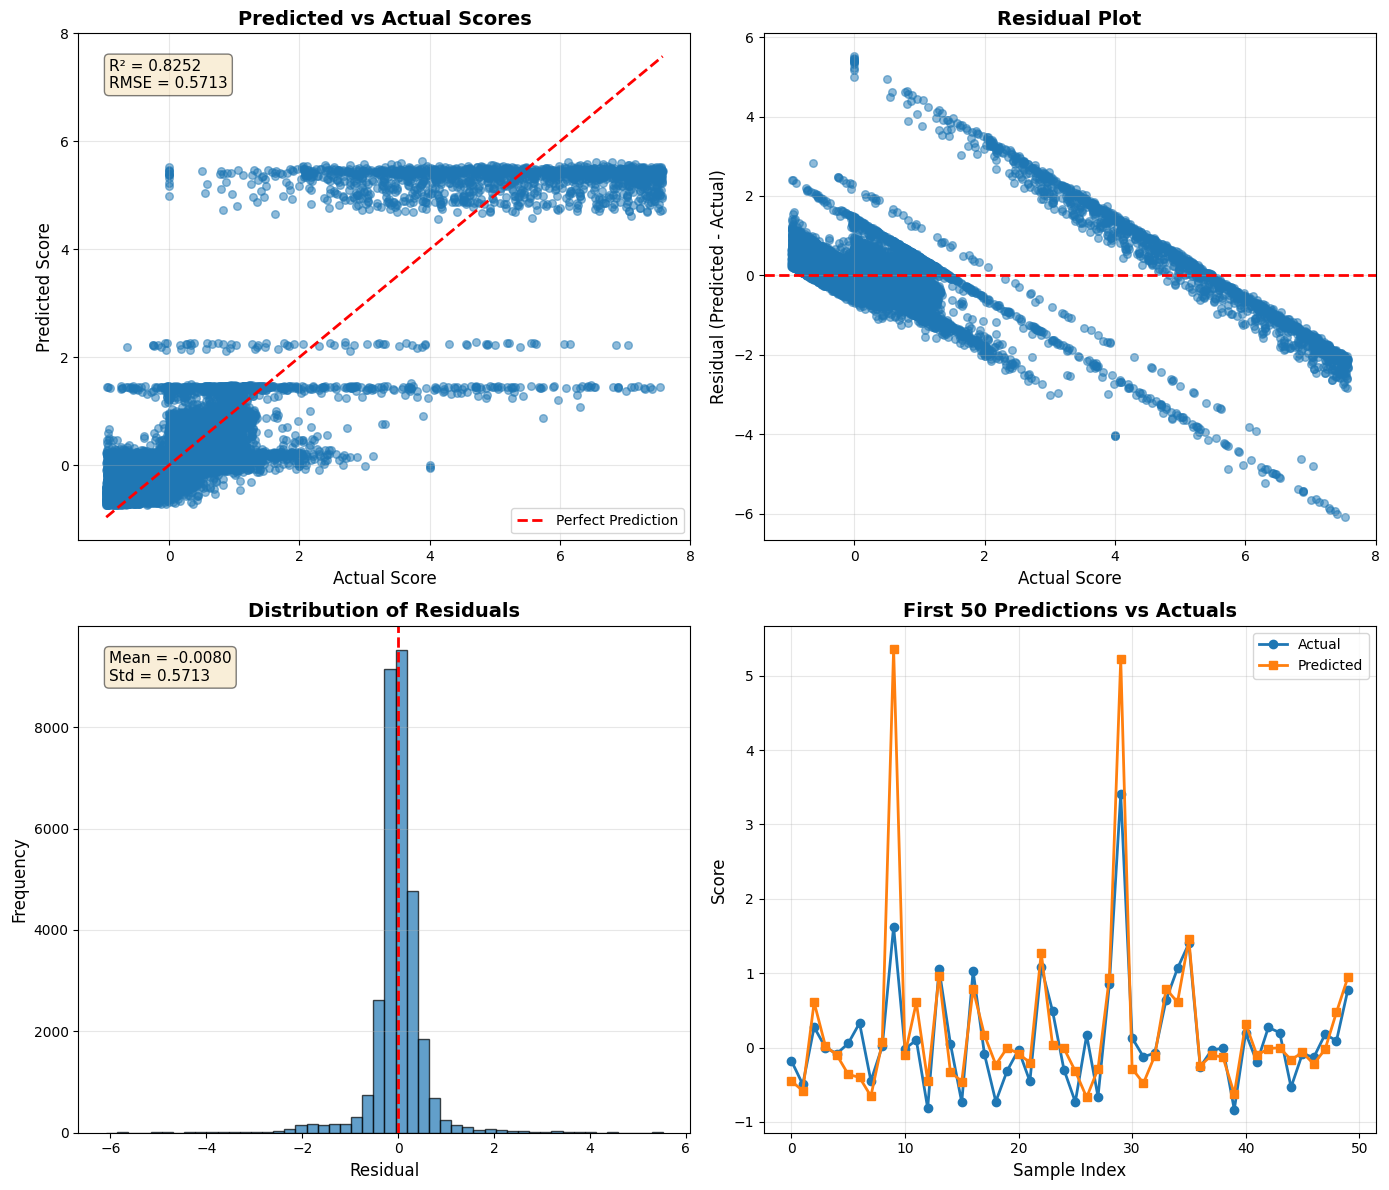


Visualizations saved to ../output/


In [16]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scatter plot: Predicted vs Actual
ax1 = axes[0, 0]
ax1.scatter(val_actuals, val_predictions, alpha=0.5, s=30)
ax1.plot([val_actuals.min(), val_actuals.max()], 
         [val_actuals.min(), val_actuals.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Score', fontsize=12)
ax1.set_ylabel('Predicted Score', fontsize=12)
ax1.set_title('Predicted vs Actual Scores', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.4f}', 
         transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Residual plot
ax2 = axes[0, 1]
residuals = val_predictions - val_actuals
ax2.scatter(val_actuals, residuals, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Actual Score', fontsize=12)
ax2.set_ylabel('Residual (Predicted - Actual)', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Distribution of residuals
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Residual', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.text(0.05, 0.95, f'Mean = {residuals.mean():.4f}\nStd = {residuals.std():.4f}', 
         transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Comparison of first N predictions
ax4 = axes[1, 1]
n_samples = min(50, len(val_actuals))
indices = np.arange(n_samples)
ax4.plot(indices, val_actuals[:n_samples], 'o-', label='Actual', linewidth=2, markersize=6)
ax4.plot(indices, val_predictions[:n_samples], 's-', label='Predicted', linewidth=2, markersize=6)
ax4.set_xlabel('Sample Index', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title(f'First {n_samples} Predictions vs Actuals', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualizations saved to ../output/")

In [ ]:
# Error analysis
errors = np.abs(residuals)
percentiles = [50, 75, 90, 95, 99]

print("\n" + "=" * 50)
print("ERROR ANALYSIS")
print("=" * 50)
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Median Absolute Error: {np.median(errors):.4f}")
print(f"Max Absolute Error: {np.max(errors):.4f}")
print(f"\nError Percentiles:")
for p in percentiles:
    print(f"  {p}th percentile: {np.percentile(errors, p):.4f}")

# Find worst predictions
worst_indices = np.argsort(errors)[-10:][::-1]
print(f"\n{'=' * 50}")
print("TOP 10 WORST PREDICTIONS")
print("=" * 50)
print(f"{'Index':<8} {'Actual':<12} {'Predicted':<12} {'Error':<12}")
print("-" * 50)
for idx in worst_indices:
    print(f"{idx:<8} {val_actuals[idx]:<12.4f} {val_predictions[idx]:<12.4f} {errors[idx]:<12.4f}")

In [21]:
# Code to generate file to submit to kaggle

# data at ../../../data/test/combined_test_data.pkl

# Load test data
print("Loading test data...")
with open('../../../data/test/combined_test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Convert to DataFrame if needed
if not isinstance(test_data, pd.DataFrame):
    test_df = pd.DataFrame(test_data)
else:
    test_df = test_data

print(f"Test dataset shape: {test_df.shape}")
print(f"Test columns: {test_df.columns.tolist()}")

# Create test dataset (no scores, so we'll pass dummy scores)
class TestProteinScoreDataset(Dataset):
    def __init__(self, dataframe, score_scaler):
        self.df = dataframe.reset_index(drop=True)
        self.score_scaler = score_scaler
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get embeddings
        ref_embedding = row['ref_embedding']
        alt_embedding = row['alt_embedding']
        
        # Ensure embeddings are torch tensors
        if not isinstance(ref_embedding, torch.Tensor):
            ref_embedding = torch.tensor(ref_embedding, dtype=torch.float32)
        else:
            ref_embedding = ref_embedding.float()
            
        if not isinstance(alt_embedding, torch.Tensor):
            alt_embedding = torch.tensor(alt_embedding, dtype=torch.float32)
        else:
            alt_embedding = alt_embedding.float()
        
        # Concatenate embeddings
        combined_embedding = torch.cat([ref_embedding, alt_embedding], dim=0)
        
        # Normalize embeddings (L2 normalization)
        norm = torch.norm(combined_embedding)
        if norm > 0:
            combined_embedding = combined_embedding / norm
        
        return combined_embedding, row['accession']

# Create test dataset and dataloader
test_dataset = TestProteinScoreDataset(test_df, train_dataset.score_scaler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"\nGenerating predictions for {len(test_df)} test samples...")

# Generate predictions
model.eval()
predictions_normalized = []
accessions = []

with torch.no_grad():
    for embeddings, batch_accessions in tqdm(test_loader, desc="Predicting"):
        embeddings = embeddings.to(device)
        
        # Skip if NaN in embeddings
        if torch.isnan(embeddings).any() or torch.isinf(embeddings).any():
            # Use median prediction for problematic samples
            preds = torch.full((embeddings.size(0),), 0.5, device=device)
        else:
            preds = model(embeddings)
            
            # Replace any NaN predictions with median
            if torch.isnan(preds).any():
                preds = torch.where(torch.isnan(preds), torch.tensor(0.5, device=device), preds)
        
        predictions_normalized.extend(preds.cpu().numpy())
        accessions.extend(batch_accessions)

# Convert to array and denormalize
predictions_normalized = np.array(predictions_normalized).reshape(-1, 1)
predictions_denormalized = train_dataset.score_scaler.inverse_transform(predictions_normalized).flatten()

# Create submission dataframe with exact format from example
submission_df = pd.DataFrame({
    'accession.score': accessions,
    '': predictions_denormalized  # Second column with empty header name
})

# Save to CSV
output_path = './output.csv'
submission_df.to_csv(output_path, index=False)

print(f"\n✓ Predictions saved to {output_path}")
print(f"\nSubmission file preview:")
print(submission_df.head(10))
print(f"\nPrediction statistics:")
print(f"Min: {predictions_denormalized.min():.4f}")
print(f"Max: {predictions_denormalized.max():.4f}")
print(f"Mean: {predictions_denormalized.mean():.4f}")
print(f"Median: {np.median(predictions_denormalized):.4f}")


Loading test data...
Test dataset shape: (118421, 10)
Test columns: ['accession', 'scoreset', 'ensp', 'pos', 'ref_long', 'alt_long', 'ref_embedding', 'alt_embedding', 'biotype', 'consequences']

Generating predictions for 118421 test samples...


Predicting: 100%|██████████| 1851/1851 [00:07<00:00, 251.38it/s]



✓ Predictions saved to ./output.csv

Submission file preview:
              accession.score          
0   urn:mavedb:00000069-a-2#1 -0.500140
1   urn:mavedb:00000069-a-2#2 -0.498225
2   urn:mavedb:00000069-a-2#3 -0.479234
3   urn:mavedb:00000069-a-2#4 -0.479952
4   urn:mavedb:00000069-a-2#5 -0.487502
5   urn:mavedb:00000069-a-2#6 -0.452543
6   urn:mavedb:00000069-a-2#7 -0.428218
7   urn:mavedb:00000069-a-2#8 -0.415917
8   urn:mavedb:00000069-a-2#9 -0.418799
9  urn:mavedb:00000069-a-2#10 -0.422954

Prediction statistics:
Min: -0.7372
Max: 5.6223
Mean: 0.5356
Median: -0.0570
